## Импортируем библиотеки

In [22]:
from sklearn.neural_network import MLPClassifier
import sklearn.preprocessing as prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


## Считываем исходные данные

In [23]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [24]:
PassengerId = test['PassengerId']

In [25]:
train.head(5)
data = [train, test]


In [26]:
colormap = plt.cm.inferno
plt.figure(figsize=(14,12))
plt.title('Pearson coef..', y=1.1, size=18)

Text(0.5,1.1,'Pearson coef..')

## Определим у кого из пассажиров есть каюты

In [27]:
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

## Создадим агрегирующие показатели состава семьи

In [28]:
for dataset in data:
    dataset['KinshipLen'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['KinshipLen'] == 1, 'IsAlone'] = 1

## Устраним пропущенные данные

In [29]:
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
for dataset in data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

/home/jesusbro/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


## Определим функцию для определения социального статуса

In [30]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

## Определим социальный статус с учетом локализации

In [31]:
for dataset in data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

## Переведем номинальные переменные в числовые

In [32]:
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test['Embarked'] = test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


## Удалим ненужные столбцы

In [33]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

## Отмасштабируем оплату на отрезок [0:1]

In [34]:
train['Fare'] = prep.scale(train['Fare'])
test['Fare'] = prep.scale(test['Fare'])

## Отобразим матрицу ранговой корреляции

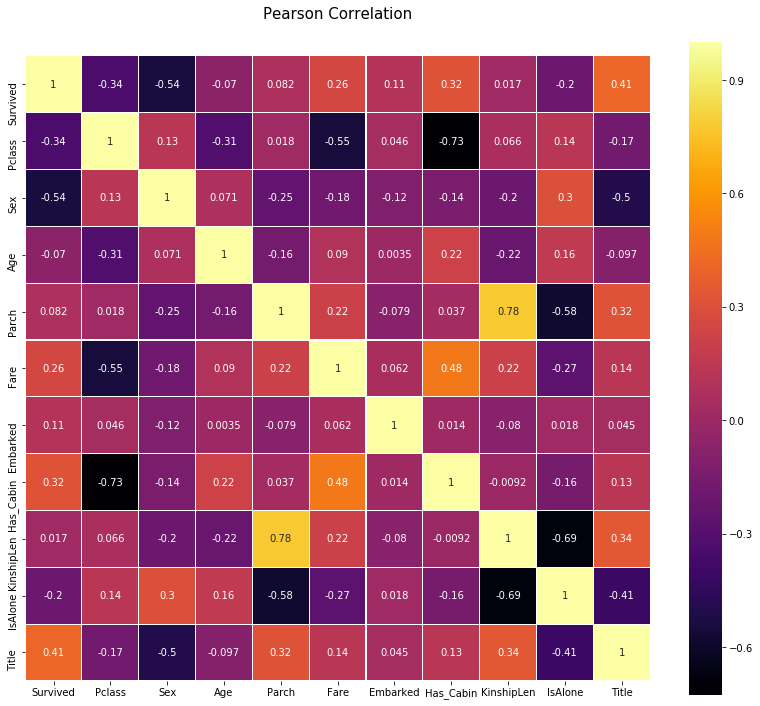

In [36]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

## Построим и обучим нейронную сеть

In [38]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(128, 512), random_state=4)

In [39]:
clf.fit(train.iloc[:, [1,2,5,7,10]].as_matrix(), train['Survived'].as_matrix())

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(128, 512), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=4, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [40]:
train.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,KinshipLen,IsAlone,Title
0,0,3,1,22,0,-0.502445,0,0,2,0,1
1,1,1,0,38,0,0.786845,1,1,2,0,3
2,1,3,0,26,0,-0.488854,0,0,1,1,2
3,1,1,0,35,0,0.420730,0,1,2,0,3
4,0,3,1,35,0,-0.486337,0,0,1,1,1


In [41]:
test.head(5)

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,KinshipLen,IsAlone,Title
0,3,1,34,0,-0.496637,2,0,1,1,1
1,3,0,47,0,-0.511497,0,0,2,0,3
2,2,1,62,0,-0.463335,2,0,1,1,1
3,3,1,27,0,-0.481704,0,0,1,1,1
4,3,0,22,1,-0.416740,0,0,3,0,3


## Проверим качество модели на тренировочной выборке

In [42]:
y_pred = clf.predict(train.iloc[:, [1,2,5,7, 10]].as_matrix())
np.sum(y_pred == train['Survived']) / float(train['Survived'].size) * 100


84.511784511784512

## Спрогнозируем значения на тестовой выборке

In [43]:
y_pred = clf.predict(test.iloc[:, [0,1,4,6, 9]].as_matrix())
output = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': y_pred })
output.to_csv("MySubmission.csv", index=False)

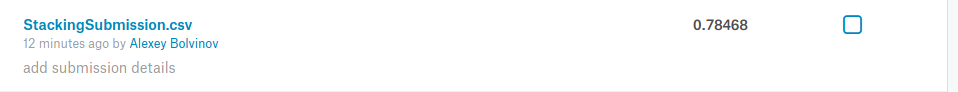

In [44]:
from IPython.display import Image
Image("./res.png")